# Image to Prompt Inference

This notebook demonstrates how to use the `img2prompt.py` module to generate prompts from images. It can process individual images or entire directories and optionally generate negative prompts as well.

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from evolutionary_imaging.img2prompt import ImageToPromptGenerator
from evolutionary_model_helpers.images import load_images


generator = ImageToPromptGenerator(debug=True)

Loading Qwen/Qwen2.5-VL-7B-Instruct on mps...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


## 1. Single Image Inference

Let's start by generating a prompt for a single image.

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



DEBUG: Input instruction:
Analyze this image for Stable Diffusion prompt generation. Return exactly two clearly labeled sections:

Positive: Detailed, comma-separated descriptors covering subject, medium, style, lighting, composition, colors, camera settings, mood, and any distinctive features. Be specific and descriptive.

Negative: Comprehensive list of comma-separated defects and unwanted elements to avoid, including technical issues (blurry, low quality, jpeg artifacts), unwanted elements (watermark, text, signature), and stylistic problems (oversaturation, poor composition).
--------------------------------------------------
DEBUG: Raw model output:
Positive: detailed street scene, painting, impressionistic, soft lighting, balanced composition, muted earthy tones, shallow depth of field, moody atmosphere, people walking, traditional storefronts, historical architecture in background

Negative: blurry, low quality, jpeg artifacts, watermark, text, signature, oversaturated colors, 

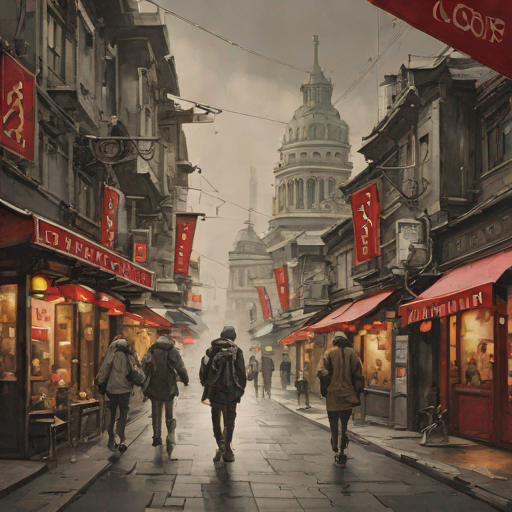

In [2]:
# Path to a test image
image_path = "./testimages/0.png"
img = Image.open(image_path)

# Generate a prompt for the image using our initialized generator
prompt = generator.generate_prompt(img, generate_negative=True)
print("Generated prompt:")
print(prompt)

# Display the image
img

In [3]:
from evolutionary_prompt_embedding.image_creation import SDXLPromptEmbeddingImageCreator
image_creator = SDXLPromptEmbeddingImageCreator(inference_steps=3, batch_size=1)

Keyword arguments {'safety_checker': None, 'requires_safety_checker': False} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



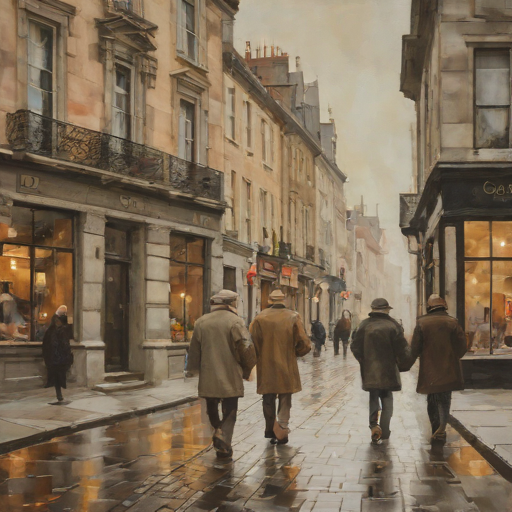

In [4]:
args = image_creator.arguments_from_prompt(prompt[0])
solution = image_creator.create_solution(args)
solution.result.images[0]

In [6]:
from evolutionary_imaging.evaluators import AestheticsImageEvaluator
evaluator = AestheticsImageEvaluator()
evaluator.evaluate(solution.result)

7.814416408538818

## 2. Generate Both Positive and Negative Prompts

In [ ]:
# Generate both positive and negative prompts using a single model call (default)
positive_prompt, negative_prompt = generator.generate_prompt(image_path, generate_negative=True)

print("Positive prompt (single call):")
print(positive_prompt)
print("\nNegative prompt (single call):")
print(negative_prompt)

# Display the image with both prompts
img = Image.open(image_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title(f"Positive: {positive_prompt}\nNegative: {negative_prompt}", fontsize=12)
plt.show()


## 3. Batch Processing of Multiple Images

Now let's process all images in a directory and display the results.

In [ ]:
# Directory containing images
image_directory = "./testimages"

# Load all images from the directory
images = load_images(image_directory)
print(f"Found {len(images)} images in {image_directory}")

In [ ]:
# Process all images in the directory using our initialized generator
start_time = time.time()
results = generator.generate_prompts_from_directory(image_directory, generate_negative=True)
elapsed_time = time.time() - start_time

print(f"Processed {len(results)} images in {elapsed_time:.2f} seconds")
print(f"Average time per image: {elapsed_time/len(results):.2f} seconds")

In [ ]:
# Display the results in a table
for result in results:
    print(f"Image: {os.path.basename(result['image_path'])}")
    print(f"Positive prompt: {result['positive_prompt']}")
    print(f"Negative prompt: {result['negative_prompt']}")
    print("-" * 80)

# Visualize the results with images and prompts
num_results = len(results)
cols = 2  # Number of columns in the grid
rows = (num_results + cols - 1) // cols  # Calculate number of rows needed

fig, axs = plt.subplots(rows, cols, figsize=(20, 5 * rows))
if rows == 1 and cols == 1:
    axs = np.array([axs])  # Make axs iterable if there's only one image
elif rows == 1:
    axs = axs.reshape(1, -1)  # Make axs 2D if there's only one row
elif cols == 1:
    axs = axs.reshape(-1, 1)  # Make axs 2D if there's only one column

# Flatten axs for easy iteration
axs_flat = axs.flatten()

for i, result in enumerate(results):
    if i < len(axs_flat):
        # Load and display the image
        img = Image.open(result['image_path'])
        axs_flat[i].imshow(img)
        axs_flat[i].axis('off')

        # Set the title with the prompts
        filename = os.path.basename(result['image_path'])
        title = f"Image: {filename}\n\nPositive: {result['positive_prompt']}\n\nNegative: {result['negative_prompt']}"
        axs_flat[i].set_title(title, fontsize=10)

# Hide any unused subplots
for i in range(num_results, len(axs_flat)):
    axs_flat[i].axis('off')
    axs_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

## 5. Saving Results to a CSV File

In [ ]:
import pandas as pd

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Save to CSV
csv_path = "./img2prompt_results.csv"
df.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")

# Display the DataFrame
df
